**Exploring Right Ventricular (RV) Sensor Arrangements via Convex Optimization**

This project aims to determine the arrangement of this sensor that optimizes the correlation between sensor strain and changes in ground truth volume, by making some approximations and utilizing convex projections.

In [ ]:
import numpy as np
from scipy.io import loadmat
from google.colab import drive 
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.spatial import ConvexHull
import statistics as st
from mpl_toolkits.mplot3d import Axes3D

# Load data
S = loadmat('/content/drive/MyDrive/ColabNotebooks/Final Project Spring 23/Hearts.mat')
V = loadmat('/content/drive/MyDrive/ColabNotebooks/Final Project Spring 23/Volume.mat')
v = V['volume_track']
H = S['All_Hearts']-1

# Load results obtained by triangulation method
E_horiz = loadmat('/content/drive/MyDrive/ColabNotebooks/Final Project Spring 23/errors_zshift.mat')
E_rotat = loadmat('/content/drive/MyDrive/ColabNotebooks/Final Project Spring 23/Errors_FINAL.mat')
matlab_best_rot = loadmat('/content/drive/MyDrive/ColabNotebooks/Final Project Spring 23/Best_sensor_rot.mat')
matlab_bad_rot = loadmat('/content/drive/MyDrive/ColabNotebooks/Final Project Spring 23/Bad_sensor_rot.mat')
matlab_best_hor = loadmat('/content/drive/MyDrive/ColabNotebooks/Final Project Spring 23/Best_sensor_hor.mat')
matlab_bad_hor = loadmat('/content/drive/MyDrive/ColabNotebooks/Final Project Spring 23/Bad_sensor_hor.mat')
matlab_ultimate = loadmat('/content/drive/MyDrive/ColabNotebooks/Final Project Spring 23/Ultimate_sensor.mat')
e_horiz = E_horiz['errors']
e_rotat = E_rotat['errors_p']
matlab_best_1 = matlab_best_rot['sensor_track']
matlab_best_2 = matlab_best_hor['sensor_track']
matlab_bad_1 = matlab_bad_rot['sensor_track']
matlab_bad_2 = matlab_bad_hor['sensor_track']
matlab_ult = matlab_ultimate['sensor_track']

# Define the feasibility halfspace boundary
c = np.array([0,1,0]).reshape((3,1))
d = -31.2208+40

# Rotate to match cutting plane 
rotz = np.array([ [-0.1736, -0.9848, 0],
    [0.9848, -0.1736, 0],
         [0, 0, 1.0000]])
for i in range(27):
  H[:,:,i] = H[:,:,i] @ rotz

# Cut all the pointclouds to simplify projections
H_cut = []
for t in range(27):
  Ht = H[:,:,t]
  H_cut = []
  for i in range(Ht.shape[0]):
    if Ht[i,1] > 30:
      H_cut.append(H[i,:])
H_cut = np.array(H_cut)

temp_h = H_cut
H_cut[:,1,:] = -temp_h[:,1,:]
H_cut[:,1,:] = temp_h[:,1,:]+40
H_cut[:,2,:] = temp_h[:,2,:]-100

# Sparsify to speed up projections
H_sparse = np.zeros((100,3,27))
for t in range(27):
  hull = ConvexHull(H_cut[:,:,t])
  convex_points = H_cut[hull.vertices,:,t]
  i = np.random.randint(0,convex_points.shape[0],100)
  H_sparse[:,:,t] = convex_points[i,:]

# We uniformly sample the error measurements from the triangulation method
idx = np.round(np.linspace(0, e_rotat.shape[0] - 1, 21)).astype(int)
e_few = e_rotat[idx]

<ipython-input-82-d4920af3c47d>:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(H[:,0,26],-H[:,1,26]+40,H[:,2,26]-100, cmap = 'PiYG')


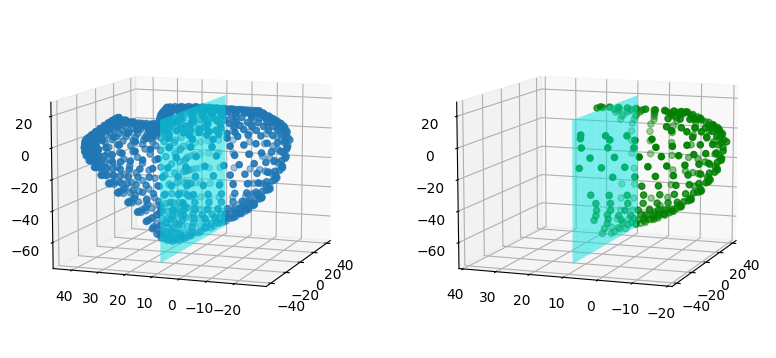

In [ ]:
"""
Visualize the convex hull compared to the original pointcloud,
along with the cutting plane
"""

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')


xx = np.linspace(-40,40,10)
yy = np.linspace(-70,20,10)

X, Z = np.meshgrid(xx, yy)
Y = d

surf = ax.plot_surface(X, Y, Z, alpha=0.5, color = 'cyan')
ax.scatter3D(H[:,0,26],-H[:,1,26]+40,H[:,2,26]-100, cmap = 'PiYG')
ax.view_init(10, -160)
ax = fig.add_subplot(1, 2, 2, projection='3d')

surf = ax.plot_surface(X, Y, Z, alpha=0.5, color = 'cyan')
ax.scatter3D(convex_points[:,0],convex_points[:,1],convex_points[:,2], color = 'green')
ax.view_init(10, -160)
plt.ylim([-20, 40])

plt.show()

In [ ]:
def project_H(x,t):
  """
  Project onto the convex hull of RV pointcloud.
  """

  # Slice the pointcloud at time t
  Ht_sparse = H_sparse[:,:,t]
  n = Ht_sparse.shape[0]

  # Solve for mixing parameter w
  w = cp.Variable((n,1))
  expr = cp.square(cp.norm(cp.sum(cp.vstack([w[i]*Ht_sparse[i,:] for i in range(n)]))-x))
  obj = cp.Minimize(expr)
  constr = [w >= 0] + [cp.sum(w) == 1]
  prob = cp.Problem(obj,constr)
  prob.solve(solver=cp.ECOS)

  # Compute the projection
  z = w.value[0]*Ht_sparse[0,:]
  for k in range(1,n):
    z = z + w.value[k]*Ht_sparse[k,:]
  return z

def project_dH(x,t):
  """
  Project onto the boundary of the convex hull.
  Note: Only works if the input point x is an interior point of the set.
  """

  # Begin by slicing the pointcloud at time t
  Ht_sparse = H_sparse[:,:,t]
  n = Ht_sparse.shape[0]
  A = Ht_sparse.T
  lambdas = []

  # We solve two LPs to find the distance to the boundary along x axis
  ej = np.zeros((3,))
  ej[0] = 1
  lambd_plus = cp.Variable()
  lambd_minus = cp.Variable()
  mu = cp.Variable(n,nonneg=True)
  obj1 = cp.Minimize(-lambd_plus)
  constr1 = [-lambd_plus*ej == A @ mu]+[cp.sum(mu) <= 1]
  prob1 = cp.Problem(obj1,constr1)
  prob1.solve(solver=cp.ECOS)
  obj2 = cp.Minimize(-lambd_minus)
  constr2 = [lambd_minus*ej == A @ mu]+[cp.sum(mu) <= 1]
  prob2 = cp.Problem(obj2,constr2)
  prob2.solve(solver=cp.ECOS)
  lambdas.append([lambd_plus.value, lambd_minus.value])

  z1 = x.copy()
  z2 = x.copy()

  # Now find the distances from boundary
  d1 = np.min(lambdas)
  d2 = np.max(lambdas)
  p1 = np.argmin(lambdas)
  p2 = np.argmax(lambdas)

  # Make sure to project into the right direction
  if p1 == 0:
    z1[0] = z1[0] + d1
    z2[0] = z2[0] - d2
  else:
    z1[0] = z1[0] - d1
    z2[0] = z2[0] + d2
  return z1, z2

def project_SC(x,a,c,d,t,shift):
  """
  Projection onto the intersection of sensor plane and cutting plane.
  """
  x = x.reshape((3,1))

  #Slice the pointcloud at time t
  Ht = H_sparse[:,:,t]

  #Find the midpoint of the RV
  zmax = max(Ht[:,2])
  zmin = min(Ht[:,2])
  zmid = (zmax+zmin)/2
  b = zmid

  if shift != 0:
    height = np.abs(zmax-zmin)
    b = zmin + shift*height

  a = a.reshape((3,1))
  c = c.reshape((3,1))
  A = np.concatenate((a.T,c.T),axis=0)
  matrix = np.eye(3) - A.T @ np.linalg.inv(A @ A.T) @ A
  vector = np.concatenate(([b],[d])).reshape((2,1))

  #Perform projection
  vector = (A.T @ np.linalg.inv(A @ A.T) @ vector)
  z = matrix @ x + vector
  return z

def box_constraints(x,t,b):
  """
  A set of linear constraints for each frame, 
  to project roughly into the pointcloud.
  """
  z = x.copy()
  x = x.reshape((3,1))
  Ht = H_sparse[:,:,t]

  xmax = max(Ht[:,0])
  ymax = max(Ht[:,1])
  zmax = max(Ht[:,2])
  xmin = min(Ht[:,0])
  ymin = min(Ht[:,1])
  zmin = min(Ht[:,2])

  if b <= 0.5:
    lower_half = np.argwhere(Ht[:,2] < (zmin+zmax)/2)
    xmax = max(Ht[lower_half,0])
    xmin = min(Ht[lower_half,0])

  if x[0] > xmax:
    scale = (x[0] - (xmax))
    z = z - np.array([scale,[0],[0]],dtype=object).reshape((3,1))
  if x[0] < xmin:
    scale = (x[0] - (xmin))
    z = z - np.array([scale,[0],[0]],dtype=object).reshape((3,1))
  if x[1] < ymin:
    scale = (x[1] - ymin)
    z = z - np.array([[0],scale,[0]],dtype=object).reshape((3,1))
  if x[1] > ymax:
    scale = (x[1] - ymax)
    z = z - np.array([[0],scale,[0]],dtype=object).reshape((3,1))
  if x[2] < zmin:
    scale = (x[2] - zmin)
    z = z - np.array([[0],[0],scale],dtype=object).reshape((3,1))
  if x[2] > zmax:
    scale = (x[2] - zmax)
    z = z - np.array([[0],[0],scale],dtype=object).reshape((3,1))
  return z

In [ ]:
def project_S(x,a,t):
  """
  Projection onto the sensor plane.
  """

  Ht = H_cut[:,:,t]
  zmax = max(Ht[:,2])
  zmin = min(Ht[:,2])
  zmid = (zmax+zmin)/2

  x = x.reshape((3,1))
  a = a.reshape((3,1))
  scale = (a.T @ x - zmid)/np.linalg.norm(a,2)
  return x - scale*a

def project_C(x):
  """
  Projection onto the feasibility halfspace.
  """
  z = x.reshape((3,1))
  if x[1] > d:
    scale = (x[1] - d)
    z = x - np.array([[0],scale,[0]],dtype=object).reshape((3,1))
  return z

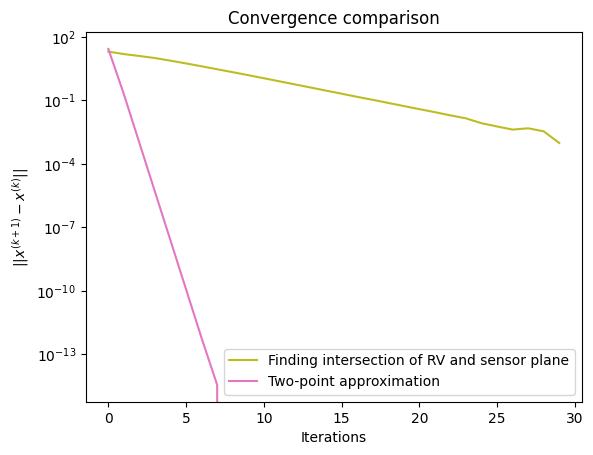

In [ ]:
""""
This part can be used to compare convergence of different projections.
"""
a1 = 0
a2 = 0
shift = 0
t = 0

a = np.array([a1,a2,1])                 # Defines the sensor plane 

for it in range(1):
  z = it*np.random.randn(3,1)           # Initialize at random
  res = []
  # We iterate through the projections to find two points on the intersection,
  # using Dykstra's alternating projection theorem
  for iter in range(30):
    x1 = project_H(z,0).reshape((3,1))
    z1 = 2*x1 - z
    x2 = project_S(z1,a,0)
    z2 = z + x2 - x1
    res.append(np.linalg.norm(x2-x1,2))
    z = z2

  plt.plot(np.array(res),color="tab:olive",label="Finding intersection of RV and sensor plane")

for point in range(1):
  a1 = np.random.uniform(-1,1)
  a = np.array([a1,0,1])                # Defines the sensor plane 
  z = np.zeros((3,1))                   # Initialize at origin
  shift = 0.5                           # Sensor plane through middle of RV
  res = []

  x11,_ = project_dH(z,t)
  for iter in range(30):
    x1 = project_SC(x11,a,c,d,t,shift)
    x1 = box_constraints(x1,t,shift)
    x1,_ = project_dH(x1,t)
    x1 = box_constraints(x1,t,shift)
    x1 = x1.astype('float')
    res.append(np.linalg.norm(x1-x11,2))
    x11 = x1
  plt.plot(res,color="tab:pink",label="Two-point approximation")


plt.xlabel("Iterations")
plt.ylabel(r'$||x^{(k+1)} - x^{(k)}||$')
plt.yscale('log')
plt.legend()
plt.title('Convergence comparison')
plt.show()

In [ ]:
def compute_1sensor_strain(a1,a2,shift,t):
  """
  For given parameters of sensor-cutting plane, two points are 
  placed on the intersection and the strain corresponding to that axis is 
  returned.
  """
  a = np.array([a1,a2,1])    # Defines the sensor plane 
  z = np.zeros((3,1))        # Initialize at origin

  # We iterate through the projections to find two points on the boundary
  x11,x22 = project_dH(z,t)
  for iter in range(10):
    x11 = project_SC(x11,a,c,d,t,shift)
    x22 = project_SC(x22,a,c,d,t,shift)
    x11 = box_constraints(x11,t,shift)
    x22 = box_constraints(x22,t,shift)
    x11,_ = project_dH(x11,t)
    _,x22 = project_dH(x22,t)
    x11 = box_constraints(x11,t,shift)
    x22 = box_constraints(x22,t,shift)

  
  x11 = x11.astype('float')
  x22 = x22.astype('float')

  # The strain at time t is approximated as the size of the two points
  # Then the strain profile can be viewed as the change between frames
  strain = np.linalg.norm(np.concatenate((x11.T,x22.T),axis=0),2)

  return strain, x11, x22

In [ ]:
def get_strain_profile(a1,a2,shift):
  """
  Compute the strain profile for given parameters.
  """
  strain_profile = np.zeros((27,1))
  for t in range(27):
    strain,_,_ = compute_1sensor_strain(a1,a2,shift,t)
    strain_profile[t] = strain
  return np.array(strain_profile)

In [ ]:
def optimize_1sensor(x = True, h = False):
  """
  This function sweeps over varying orientations of the sensor plane
  around the x-axis, computing the difference from
  the ideal strain profile, and returning the orientation that minimizes it.
  """
  # Normalize the volume changes for comparison
  true = (v-np.min(v))/np.max(v)
  optimal_a = 0
  optimal_shift = 0
  best_error = 100

  if x: 
    a1 = -1
    a2 = 0
    error_tracked = []
    while a1 <= 1:
      s = -get_strain_profile(a1,0,0.5)
      s_norm = (s-np.min(s))/(np.max(s))
      error = np.square(np.subtract(true,-s_norm)).mean()
      if error <= best_error:
        best_error = error
        optimal_a = a1
      error_tracked.append(error)
      a1 = a1 + 0.1

  if h:
    a1 = 0
    a2 = 0
    shift = 0.2
    error_tracked = []
    while shift <= 0.8:
      s = -get_strain_profile(0,0,shift)
      s_norm = (s-np.min(s))/(np.max(s))
      error = np.square(np.subtract(true,-s_norm)).mean()
      if error <= best_error:
        best_error = error
        optimal_shift = shift
      error_tracked.append(error)
      shift = shift + 0.05

  errors = np.array(error_tracked)

  return errors, optimal_a, optimal_shift
  

In [ ]:
"""
Note: This takes approximately 6 minutes to run
"""
error_x, a1_opt, _ = optimize_1sensor(x = True, h = False) # Sweeping rotations over x axis

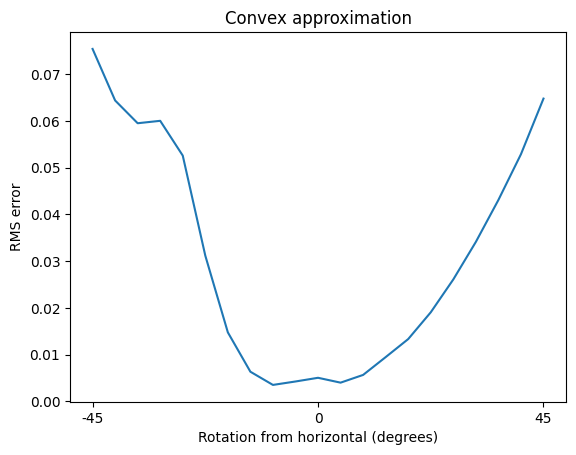

In [ ]:
plt.plot(error_x)
plt.xticks([0,10,20],['-45','0','45'])
plt.xlabel('Rotation from horizontal (degrees)')
plt.ylabel('RMS error')
plt.title("Convex approximation")
plt.show()

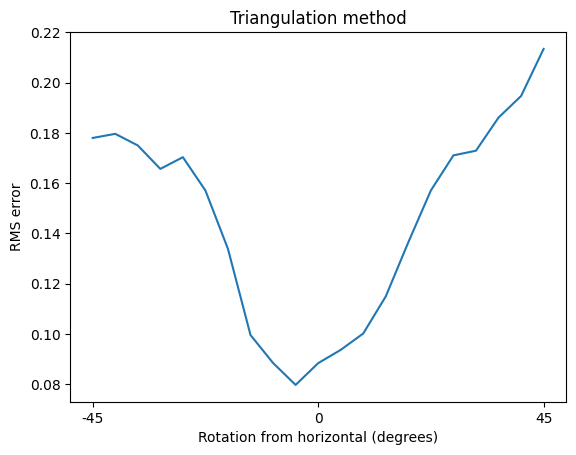

In [ ]:
plt.plot(e_few)
plt.xticks([0,10,20],['-45','0','45'])
plt.xlabel('Rotation from horizontal (degrees)')
plt.ylabel('RMS error')
plt.title('Triangulation method')
plt.show()

In [ ]:
"""
Note: This takes approximately 2.5 minutes to run
"""
error_y, _, shift = optimize_1sensor(x = False, h = True) # Shifting plane over z axis

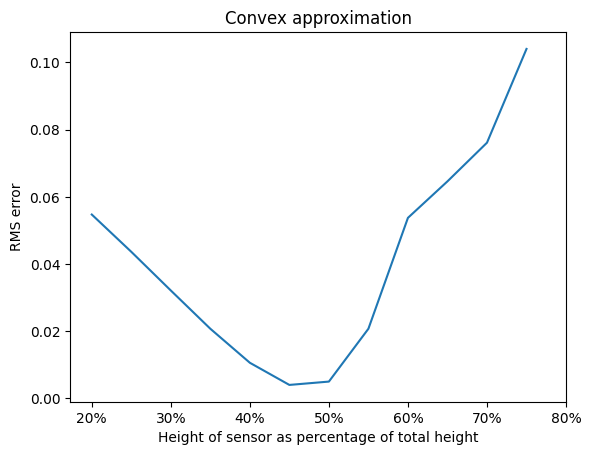

In [ ]:
plt.plot(error_y)
plt.xticks([0,2,4,6,8,10,12],['20%','30%','40%','50%','60%','70%','80%'])
plt.xlabel('Height of sensor as percentage of total height')
plt.ylabel('RMS error')
plt.title("Convex approximation")
plt.show()

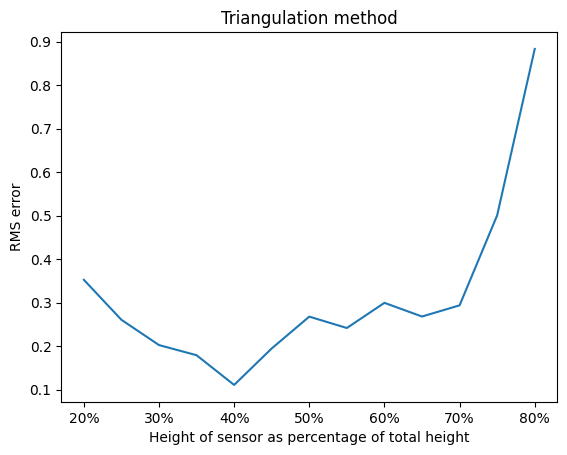

In [ ]:
plt.plot(e_horiz)
plt.xticks([0,2,4,6,8,10,12],['20%','30%','40%','50%','60%','70%','80%'])
plt.xlabel('Height of sensor as percentage of total height')
plt.ylabel('RMS error')
plt.title('Triangulation method')
plt.show()

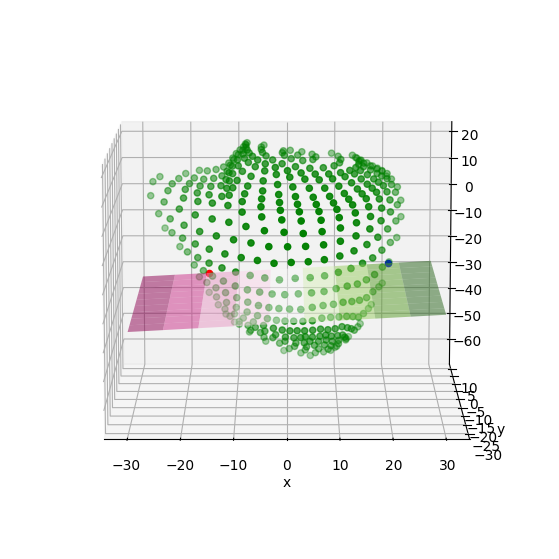

In [ ]:
"""
To visualize sensor points on 3D pointcloud
"""
t = 0
a1 = -0.1
a2 = 0
shift = 0.4

_, x1, x2 = compute_1sensor_strain(a1,a2,shift,t)

Ht = H_cut[:,:,t]
a = np.array([a1,a2,1])
zmax = max(Ht[:,2])
zmin = min(Ht[:,2])
zmid = (zmax+zmin)/2
height = np.abs(zmax-zmin)
b = zmin + shift*height

xx = np.linspace(-30,30,10)
yy = np.linspace(-30,10,10)

X,Y = np.meshgrid(xx,yy)
Z = (b - a1*X - a2*Y)

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, alpha=0.5, cmap = 'PiYG')
ax.scatter3D(H_cut[:,0,t],H_cut[:,1,t],H_cut[:,2,t], color = "green")
ax.scatter3D(x1[0],x1[1],x1[2], color = "red")
ax.scatter3D(x2[0],x2[1],x2[2], color = "blue")
ax.view_init(10, -90)
plt.ylabel('y')
plt.xlabel('x')
plt.show()